# Question 1

### Imports

In [50]:
# install libraries
!pip install newspaper3k
!pip install newsapi-python
!pip install afinn

# import libraries
import pandas as pd
import plotly.express as px
import seaborn as sns 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

sns.set_style()

from newsapi import NewsApiClient
from newspaper import Article
from newspaper import Config
import nltk

nltk.download('punkt')

from textblob import TextBlob
from afinn import Afinn

import requests
from bs4 import BeautifulSoup
import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Description of the fourth wave

In [ ]:
# create directories
!mkdir ./datasets
!mkdir ./datasets/covid

!wget https://www.data.gouv.fr/fr/datasets/r/d3a98a30-893f-47f7-96c5-2f4bcaaa0d71  -O ./datasets/covid/france_covid.csv

In [13]:
# deownload data about the covid19 in france
covid_df = pd.read_csv('./datasets/covid/france_covid.csv')
covid_df = covid_df[['date', 'total_cas_confirmes', 'total_deces_hopital']]

# fill empty dates
dates = pd.date_range(start = covid_df['date'].min(), end= covid_df['date'].max())
covid_df['date'] = dates

# remove na values and duplicates
covid_df = covid_df.dropna().drop_duplicates()

# calcualte the number of cases for each day - subtract the next day from the previous beacuse cumulation
covid_df['cases_per_day'] = covid_df['total_cas_confirmes'].diff(periods=1).fillna(covid_df['total_cas_confirmes'])

# calcualte the number of hospitals for each day - subtract the next day from the previous beacuse cumulation
covid_df['hospitals_per_day'] = covid_df['total_deces_hopital'].diff(periods=1).fillna(covid_df['total_deces_hopital'])

# remove rows where the number of cases is less than 0
covid_df = covid_df[covid_df['cases_per_day'] > 0]
covid_df = covid_df[covid_df['hospitals_per_day'] > 0]
covid_df

,date,total_cas_confirmes,total_deces_hopital,cases_per_day,hospitals_per_day
0,2020-03-02,191.0,3,191.0,3.0
1,2020-03-03,212.0,4,21.0,1.0
3,2020-03-05,423.0,7,138.0,3.0
4,2020-03-06,613.0,9,190.0,2.0
5,2020-03-07,949.0,16,336.0,7.0
...,...,...,...,...,...
681,2022-01-12,12934982.0,99093,361719.0,246.0
682,2022-01-13,13240304.0,99318,305322.0,225.0
683,2022-01-14,13569675.0,99509,329371.0,191.0
684,2022-01-15,13894255.0,99657,324580.0,148.0


In [14]:
# plot the number of cases for each day in france
fig = px.bar(covid_df, x='date', y='cases_per_day', title='Cases Per Day in France')
fig.show()

In [15]:
# plot the number of hospitals for each day in france
fig = px.bar(covid_df, x='date', y='hospitals_per_day', title='Number of hospitals pre day in France')
fig.show()

In [16]:
# Init the news api
newsapi = NewsApiClient(api_key='8764ed860cae4c0287ad997fbfbc6b3b')

all_articles = []

# get articles from the newsAPI 3 weeks earlier, with the query of "france coronavirus" and only in the english language
for i in range(1, 6):
  articles_page = newsapi.get_everything(q='france coronavirus',
                                      from_param='2021-12-29',
                                      language='en',
                                      sort_by='relevancy',
                                      page=i)
  all_articles.extend(articles_page['articles'])

In [17]:
# set headers in order to use GET queries like a browser
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36'
headers = {'User-Agent': user_agent}
config = Config()
config.browser_user_agent = user_agent

In [18]:
# get only required columns
news_df = pd.DataFrame(columns=['Date', 'Title', 'Article', 'Summary'])
articles_list = []

# iterate over each result and get its date, title, article and summary using the Article object
for article in all_articles:
  try:
      articles_dict = {}
      article_obj = Article(article['url'], config=config)
      article_obj.download()
      article_obj.parse()
      article_obj.nlp()
      articles_dict['Date']    = article['publishedAt']
      articles_dict['Title']   = article['title']
      articles_dict['Article'] = article_obj.text
      articles_dict['Summary'] = article_obj.summary
      articles_list.append(articles_dict)
  except Exception as e:
    pass
  
# convert result into dataframe
news_df=pd.DataFrame(articles_list)

Text(0.5, 1.0, 'Number of articles about Covid in France')

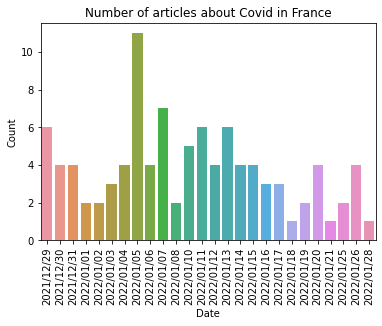

In [19]:
# transform date into the following format '%Y/%m/%d'
news_df['Date'] = pd.to_datetime(news_df['Date'], dayfirst=True)
news_df['Date'] = news_df['Date'].dt.strftime('%Y/%m/%d')

# groupby the articles by date
news_df_gb = news_df.groupby(news_df['Date']).size().reset_index(name='Count')

# show number of articles about the corona in france for each day
plt.xticks(rotation=90)
sns.barplot(data=news_df_gb, x='Date', y='Count')
plt.title('Number of articles about Covid in France')

In [20]:
# calculate sentiment - if score gt 0 positive, lt negative else neutral
def set_sentiment(score):
  if score == 0.0:
    return 'neutral'
  elif score > 0:
    return 'positive'
  return 'negative'

In [21]:
# calc textblob score for every title
news_df['textblob_score'] = news_df['Title'].apply(lambda t: TextBlob(t).sentiment.polarity)

# add sentiment column only for the title
news_df['Sentiment'] = news_df['textblob_score'].apply(lambda score: set_sentiment(score))

# count the number of sentiments for each day
new_df_sen = news_df.groupby(['Date', 'Sentiment']).size().reset_index(name='CountSentiment')

# plot the result
fig = px.bar(new_df_sen, x="Date", y="CountSentiment",
             color='Sentiment', barmode='group',
             height=400,
             title='Count Article Title Sentiments per Day in France Over The Fifth Covid19 Wave - using TextBlob')
fig.show()

In [22]:
# calc textblob score for every article
news_df['textblob_score_article'] = news_df['Article'].apply(lambda t: TextBlob(t).sentiment.polarity)

# add sentiment column for the full article
news_df['Sentiment_article'] = news_df['textblob_score_article'].apply(lambda score: set_sentiment(score))

# count the number of sentiments for each day
new_df_sen = news_df.groupby(['Date', 'Sentiment_article']).size().reset_index(name='CountSentiment_article')

# plot the result
fig = px.bar(new_df_sen, x="Date", y="CountSentiment_article",
             color='Sentiment_article', barmode='group',
             height=400,
             title='Count Article Sentiments per Day in France Over The Fifth Covid19 Wave - using TextBlob')
fig.show()

In [23]:
afinn = Afinn()

# calc affinity score for every title
news_df['affin_score_title'] = news_df['Title'].apply(lambda t: afinn.score(t))

# add sentiment column only for the title
news_df['Affin_Sentiment_title'] = news_df['affin_score_title'].apply(lambda score: set_sentiment(score))

# count the number of sentiments for each day
new_df_sen = news_df.groupby(['Date', 'Affin_Sentiment_title']).size().reset_index(name='CountSentiment_affin_title')

# plot the result
fig = px.bar(new_df_sen, x="Date", y="CountSentiment_affin_title",
             color='Affin_Sentiment_title', barmode='group',
             height=400,
             title='Count Article Title Sentiments per Day in France Over The Fifth Covid19 Wave - using Affin')
fig.show()

In [24]:
afinn = Afinn()

# calc affinity score for every article
news_df['affin_score_article'] = news_df['Article'].apply(lambda t: afinn.score(t))

# add sentiment column for the full article
news_df['Affin_Sentiment_article'] = news_df['affin_score_article'].apply(lambda score: set_sentiment(score))

# count the number of sentiments for each day
new_df_sen = news_df.groupby(['Date', 'Affin_Sentiment_article']).size().reset_index(name='CountSentiment_affin_article')

fig = px.bar(new_df_sen, x="Date", y="CountSentiment_affin_article",
             color='Affin_Sentiment_article', barmode='group',
             height=400,
             title='Count Article Sentiments per Day in France Over The Fifth Covid19 Wave - using Affin')
fig.show()

In [25]:
# scrapping
france24_articles = []

# url of coronavirus section in the required site
url='https://www.france24.com/en/tag/coronavirus/'
# main url
dir_path = 'https://www.france24.com'

# scrap the site from page 1 until page 20
for i in tqdm(range(1, 20)):
  response = requests.get(url, headers=headers)  
  soup = BeautifulSoup(response.text, 'html.parser')
  headlines = soup.find_all("div", {"class": "m-item-list-article"})
  
  for x in headlines:
    try:
      article_dict = {}
      
      try:
        article_url = dir_path + x.find('a', href=True)['href']

        article_obj = Article(article_url, config=config)
        article_obj.download()
        article_obj.parse()
        article_obj.nlp()
        article_dict['Article'] = article_obj.text
      
      except Exception as e:
        article_dict['Article'] = 'Nan'

      article_dict['Date'] = x.time.text.strip()
      article_dict['Title']   = x.find("p", {'class': 'article__title '}).text.strip()

      france24_articles.append(article_dict)

    except Exception as e:
        print(e)
    
  url = f'https://www.france24.com/en/tag/coronavirus/{i+1}/'

france24_news_df = pd.DataFrame(france24_articles)
france24_news_df = france24_news_df[['Date', 'Title', 'Article']] # reorder columns
france24_news_df.to_csv('france24.csv', index=False)
france24_news_df

100%|██████████| 19/19 [01:19<00:00,  4.18s/it]


,Date,Title,Article
0,29/01/2022,'Swipe left for unvaxxed’: Vaccine status comp...,Since the vaccine pass came into force in Fran...
1,29/01/2022,"German workers hail minimum wage hike, but emp...",Germany is raising the minimum wage by €12 an ...
2,29/01/2022,Folk music legend Joni Mitchell joins Neil You...,Folk music legend Joni Mitchell attends the 44...
3,28/01/2022,London police deny that they are delaying UK g...,A police officer walks past the door to 10 Dow...
4,28/01/2022,"Ukraine Diplomacy continues, a coup in Burkina...","Ukraine Diplomacy continues, a coup in Burkina..."
...,...,...,...
451,24/09/2021,Covid passport: Do they work?,Covid passport: Do they work?\n\nTALKING EUROP...
452,24/09/2021,Why are the French so sceptical about vaccines?,Why are the French so sceptical about vaccines...
453,24/09/2021,Britain vows to resolve trucker shortage amid ...,Britain on Friday vowed to do whatever it take...
454,23/09/2021,Biden says US donating 'historic' extra 500 mi...,Page not found\n\nThe content you requested do...


In [26]:
# get only papers which contain the words france/french (all the papers are about coronavirus hence don't need to osearch for it)
def find_only_france_articles(t):
  return 'france' in t.lower() or'french' in t.lower()

# get only papers from from the fifth wave range of dates
def find_fourth_wave_articels(d):
  start = datetime.datetime(2021, 10, 1)
  end = datetime.datetime(2022, 1, 15)
  current = datetime.datetime.strptime(d, '%d/%m/%Y')
  return current >= start and current <= end

# filter articles only about the coronavirus in france and only in the fifth wave.
france24_news_df_clean = france24_news_df[france24_news_df['Title'].apply(lambda t: find_only_france_articles(t))]
france24_news_df_clean = france24_news_df_clean[france24_news_df_clean['Date'].apply(lambda d: find_fourth_wave_articels(d))]
france24_news_df_clean

,Date,Title,Article
91,14/01/2022,Teachers in France stage massive walk-out over...,Teachers and school personnel march during a d...
94,13/01/2022,France eases UK travel restrictions,France eases UK travel restrictions\n\nFrance ...
97,13/01/2022,Teachers in France stage massive walk-out over...,Teachers and school personnel march during a d...
98,13/01/2022,"Sweating it out: France's education minister, ...","Sweating it out: France's education minister, ..."
100,13/01/2022,French Senate passes amended bill transforming...,France’s Senate voted early Thursday morning t...
...,...,...,...
375,05/11/2021,French hotel industry ‘on its knees’ due to st...,Sebastien Bazin said many hotel industry emplo...
376,05/11/2021,French MPs approve continued use of Covid heal...,French lawmakers on Friday approved the contin...
424,14/10/2021,Covid health pass prevails over French vaccine...,France’s introduction of a controversial healt...
425,14/10/2021,Rising fertiliser prices may prompt French far...,Surging prices and tight supply of fertilisers...


In [27]:
# example of one article
print('Title: ')
print(france24_news_df_clean.iloc[0]['Title'])
print('\n')
print('Full article: ')
print(france24_news_df_clean.iloc[0]['Article'])

Title: 
Teachers in France stage massive walk-out over Covid confusion


Full article: 
Teachers and school personnel march during a demonstration in Marseille, southern France, on January 13, 2022, to denounce the "indescribable mess" caused by the government's new measures to curb the spread of Covid-19.

© Clement Mahoudeau, AFP


### Comparison between the second wave to the fourth wave

In [ ]:
# download required dataset
!wget https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest_combined.csv -O ./datasets/covid/policy_restrictions.csv

In [29]:
# load dataset, filter by country select only france data only, and select the three selected subjects -
# C1 schools, C2 workplaces, C5 publid transportation, C7 interanl transportation, C8 international transportation
df = pd.read_csv('./datasets/covid/policy_restrictions.csv')
df = df[df['CountryName'] == 'France']
df = df[['CountryName', 'Date', 'C1_combined_numeric', 'C2_combined_numeric', 'C5_combined_numeric', 'C7_combined_numeric', 'C8_combined_numeric']]
print("Number of na values: ", df.isna().sum())
df.dropna(axis=0, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3,39,41,43) have mixed types.Specify dtype option on import or set low_memory=False.



Number of na values:  CountryName            0
Date                   0
C1_combined_numeric    1
C2_combined_numeric    1
C5_combined_numeric    1
C7_combined_numeric    1
C8_combined_numeric    1
dtype: int64


,CountryName,Date,C1_combined_numeric,C2_combined_numeric,C5_combined_numeric,C7_combined_numeric,C8_combined_numeric
98040,France,20200101,0.0,0.0,0.0,0.0,0.0
98041,France,20200102,0.0,0.0,0.0,0.0,0.0
98042,France,20200103,0.0,0.0,0.0,0.0,0.0
98043,France,20200104,0.0,0.0,0.0,0.0,0.0
98044,France,20200105,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
98794,France,20220124,1.0,2.0,2.0,2.0,3.0
98795,France,20220125,1.0,2.0,2.0,2.0,3.0
98796,France,20220126,1.0,2.0,2.0,2.0,3.0
98797,France,20220127,1.0,2.0,2.0,2.0,3.0


In [30]:
# convert the date column into datetime object
def set_date(d):
  d = str(d)
  year = d[:4]
  month = d[4:6]
  day = d[6:]
  date = datetime.datetime(int(year), int(month), int(day))
  return date

df['Date'] = df['Date'].apply(lambda d: set_date(d))

In [31]:
# split data into the first wave and fifth wave
df_first_wave = df[(df['Date'] <= datetime.datetime(2020, 5, 30)) & (df['Date'] >= datetime.datetime(2020, 3, 1))]
df_fifth_wave = df[df['Date'] >= datetime.datetime(2021, 10, 1)]

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# plot comaprison between the two waves
def compare_waves(labels, first_values, second_values, first_name, second_name, title):
  """
  labels: labels restrictions possible for this section
  first_values: restriction in the first wave
  second_values: restrictions in the fifth wave
  first_name: 'first wave'
  second_name: 'fifth_wave'
  title: the plot title
  """
  # Create subplots: use 'domain' type for Pie subplot
  fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
  fig.add_trace(go.Pie(labels=labels, values=first_values, name=first_name),
                1, 1)
  fig.add_trace(go.Pie(labels=labels, values=second_values, name=second_name),
                1, 2)

  # Use `hole` to create a donut-like pie chart
  fig.update_traces(hole=.4, hoverinfo="label+percent+name")

  fig.update_layout(
      title_text=f"Compare First and Fifth Wave - {title}",
      # Add annotations in the center of the donut pies.
      annotations=[dict(text='1st Wave', x=0.18, y=0.5, font_size=20, showarrow=False),
                  dict(text='5th Wave', x=0.82, y=0.5, font_size=20, showarrow=False)])
  fig.show()

In [41]:
# get dictionary of number of days with specific restriction over the given wave (first or fifth)
def get_restrictions(column, wave_df, num_values, flag=True):
  # group by restriction and count the number of days it was over the given wave
  df_wave_gb = wave_df.groupby(column).size().reset_index(name='counts')
  df_wave_dict = {}
  if flag:
    for i in np.arange(0.0, num_values + 0.5, 0.5):
      df_wave_dict[i] = 0
  else:
    for i in np.arange(0.0, num_values + 1.0, 1.0):
      df_wave_dict[i] = 0
  
  for value in df_wave_gb[column].values:
    df_wave_dict[value] = df_wave_gb[df_wave_gb[column] == value]['counts'].iloc[0]
  
  return df_wave_dict

In [42]:
# schools - plot comparison
df_first_wave_schools_dict = get_restrictions('C1_combined_numeric', df_first_wave, 3)
df_fifth_wave_schools_dict = get_restrictions('C1_combined_numeric', df_fifth_wave, 3)
school_labels = ["No restrictions", "Recommended restrictions (targeted)", "Recommended restrictions (general)",
          "Require closing some levels (targeted)", "Require closing some levels (general)", 
          "Require closing all levels (targeted)", "Require closing all levels (general)"]
school_first_name = "School Restrictions First Wave"
school_second_name = "School Restrictions Fifth Wave"
school_title = 'Education System'
school_first_values = list(df_first_wave_schools_dict.values())
school_second_values = list(df_fifth_wave_schools_dict.values())
compare_waves(school_labels, school_first_values, school_second_values,
              school_first_name, school_second_name, school_title)

In [43]:
# workplaces
df_first_wave_workplaces_dict = get_restrictions('C2_combined_numeric', df_first_wave, 3)
df_fifth_wave_workplaces_dict = get_restrictions('C2_combined_numeric', df_fifth_wave, 3)
workplace_labels = ["No restrictions", "Recommended closing (targeted)", "Recommended closing (general)",
          "Require closing for some sectors (targeted)", "Require closing for some sectors (general)", 
          "Require closing for all but essential workplaces (targeted)", "Require closing for all but essential workplaces (general)"]
workplace_first_name = "Workplaces Restrictions First Wave"
workplace_second_name = "Workplaces Restrictions Fifth Wave"
workplace_title = 'Workplaces'
workplace_first_values = list(df_first_wave_workplaces_dict.values())
workplace_second_values = list(df_fifth_wave_workplaces_dict.values())
compare_waves(workplace_labels, workplace_first_values, workplace_second_values, 
              workplace_first_name, workplace_second_name, workplace_title)

In [44]:
#public transportation
df_first_wave_public_transport_dict = get_restrictions('C5_combined_numeric', df_first_wave, 2)
df_fifth_wave_public_transport_dict = get_restrictions('C5_combined_numeric', df_fifth_wave, 2)
public_transport_labels = ["No restrictions", "Recommended closing or reduce volume (targeted)", 
                           "Recommended closing or reduce volume (general)",
          "Require closing or prohibit most citizens from using it (targeted)", 
          "Require closing or prohibit most citizens from using it  (general)"]
public_transport_first_name = "Public transportation Restrictions First Wave"
public_transport_second_name = "Public transportation Restrictions Fifth Wave"
public_transport_title = 'Public transportation System'
public_transport_first_values = list(df_first_wave_public_transport_dict.values())
public_transport_second_values = list(df_fifth_wave_public_transport_dict.values())
compare_waves(public_transport_labels, public_transport_first_values, public_transport_second_values, 
              public_transport_first_name, public_transport_second_name, public_transport_title)

In [47]:
# national transportation 
df_first_wave_internal_movement_dict = get_restrictions('C7_combined_numeric', df_first_wave, 2) 
df_fifth_wave_internal_movement_dict = get_restrictions('C7_combined_numeric', df_fifth_wave, 2)
internal_movement_labels = ["No restrictions", "Recommended not to travel between cities (targeted)", 
                           "Recommended not to travel between cities (general)", 
                            "Internal movement restrictions in place (targeted)", 
                            "Internal movement restrictions in place (general)"]
internal_movement_first_name = "Internal movement Restrictions First Wave"
internal_movement_second_name = "Internal movement Restrictions Fifth Wave"
internal_movement_title = 'Internal movement'
internal_movement_first_values = list(df_first_wave_internal_movement_dict.values())
internal_movement_second_values = list(df_fifth_wave_internal_movement_dict.values())
compare_waves(internal_movement_labels, internal_movement_first_values, internal_movement_second_values, 
              internal_movement_first_name, internal_movement_second_name, internal_movement_title)

In [48]:
# international transportation
df_first_wave_international_travel_dict = get_restrictions('C8_combined_numeric', df_first_wave, 4, flag=False) 
df_fifth_wave_international_travel_dict = get_restrictions('C8_combined_numeric', df_fifth_wave, 4, flag=False)
international_travel_labels = ["No restrictions", "Screening arrivals", 
                           "Quarantine arrivals from some or all regions", 
                            "Ban arrivals from some regions", 
                            "Ban on all regions or total border closure"]
international_travel_first_name = "International travel Restrictions First Wave"
international_travel_second_name = "International travel Restrictions Fifth Wave"
international_travel_title = 'International travel'
international_travel_first_values = list(df_first_wave_international_travel_dict.values())
international_travel_second_values = list(df_fifth_wave_international_travel_dict.values())
compare_waves(international_travel_labels, international_travel_first_values, international_travel_second_values, 
              international_travel_first_name, international_travel_second_name, international_travel_title)

# Question 2

### Import

In [ ]:
# install required packages
!pip install kaggle 
!pip install turicreate
!pip install networkx
!pip install spaCy
!python -m spacy download en_core_web_md # Important! you need to restart runtime after install

In [25]:
# genneral libraries
import json
import os
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# networkx, turicreate
import networkx as nx
import turicreate as tc 
import turicreate.aggregate as agg

# to find communities
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities

# topic modeling
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from collections import Counter
import re
from nltk.stem.porter import *
import operator

# entity recognition
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.util import minibatch, compounding

nlp = spacy.load('en_core_web_md')

from collections import Counter
from tqdm.notebook import tqdm as nt_tqdm
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [3]:
# set kaggle api token
api_token = {"username":"amitdamri","key":"a076ad6676498fde930f6aacbda924c4"}

# create kaggle file if not exists
if not os.path.exists('/root/.kaggle') or not os.path.isdir('/root/.kaggle'):
  !mkdir /root/.kaggle/
  
# creating kaggle.json file with the personal API-Key details
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Creating a dataset directory
if not os.path.exists('./datasets') or not os.path.isdir('./datasets'):
  !mkdir ./datasets

# create meta kaggle dir
!mkdir ./datasets/meta-kaggle

# download the dataset from Kaggle and unzip it 
!kaggle datasets download -d kaggle/meta-kaggle -p ./datasets/meta-kaggle
!unzip ./datasets/meta-kaggle/*.zip  -d ./datasets/meta-kaggle/

# delete all zip files
directory = './datasets/meta-kaggle'
for file in os.listdir(directory):
  if file.endswith('.zip'):
    os.remove(os.path.join(directory, file))

100% 4.52G/4.52G [01:23<00:00, 37.1MB/s]

Archive:  ./datasets/meta-kaggle/meta-kaggle.zip
  inflating: ./datasets/meta-kaggle/CompetitionTags.csv  
  inflating: ./datasets/meta-kaggle/Competitions.csv  
  inflating: ./datasets/meta-kaggle/DatasetTags.csv  
  inflating: ./datasets/meta-kaggle/DatasetTaskSubmissions.csv  
  inflating: ./datasets/meta-kaggle/DatasetTasks.csv  
  inflating: ./datasets/meta-kaggle/DatasetVersions.csv  
  inflating: ./datasets/meta-kaggle/DatasetVotes.csv  
  inflating: ./datasets/meta-kaggle/Datasets.csv  
  inflating: ./datasets/meta-kaggle/Datasources.csv  
  inflating: ./datasets/meta-kaggle/EpisodeAgents.csv  
  inflating: ./datasets/meta-kaggle/Episodes.csv  
  inflating: ./datasets/meta-kaggle/ForumMessageVotes.csv  
  inflating: ./datasets/meta-kaggle/ForumMessages.csv  
  inflating: ./datasets/meta-kaggle/ForumTopics.csv  
  inflating: ./datasets/meta-kaggle/Forums.csv  
  inflating: ./datasets/meta-kaggle/KernelLanguages.csv  
  inflating: ./datas

### Build Network and Find central communities

In [5]:
# read TeamMemberships data into an sframe
meta_sf = tc.SFrame.read_csv(os.path.join('./datasets/meta-kaggle', 'TeamMemberships.csv'))

# create graph
meta_g = nx.Graph()

# add users as nodes
meta_g.add_nodes_from(meta_sf['UserId'])

# get all users in each team
teams = meta_sf.groupby('TeamId', {"UsersInTeam": agg.CONCAT('UserId')})

# append an edge between each user in each team
edges = []
for users in teams['UsersInTeam']:
  if len(users) > 1:
    for (u1, u2) in itertools.combinations(users, 2):
      edges.append((u1, u2))
meta_g.add_edges_from(edges)

# pring graph info
print(nx.info(meta_g))

Read 100 lines. Lines per second: 20.5136

Finished parsing file /content/datasets/meta-kaggle/TeamMemberships.csv

Parsing completed. Parsed 100 lines in 4.87628 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 2441327 lines. Lines per second: 475127

Finished parsing file /content/datasets/meta-kaggle/TeamMemberships.csv

Parsing completed. Parsed 4983748 lines in 7.18692 secs.

Graph with 1796829 nodes and 180677 edges


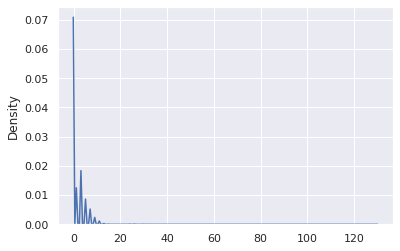

In [6]:
# visualize the distribution of nodes' degree
nodes_degree = meta_g.degree()
# sns.distplot([degree for degree in dict(nodes_degree).values()], binwidth=0.1)
sns.kdeplot([degree for degree in dict(nodes_degree).values()])
# plt.ylim((0, 1e3))

We can see that the graph has many nodes, hence I will prone nodes which have a few teammates.

In [7]:
# let's create a list with nodes that have degree > 1
selected_nodes_list = [node for node, degree in dict(nodes_degree).items() if degree > 3]
# create a subgraph with only nodes from the above list
meta_sub = meta_g.subgraph(selected_nodes_list)
print(nx.info(meta_sub))

Graph with 27674 nodes and 71313 edges


In [8]:
# find communities
# communities = list(girvan_newman(meta_sub))
communities = greedy_modularity_communities(meta_sub)
print("Total communities found: ", len(communities))

Total communities found:  4840


In [9]:
# print number of nodes in each community
len_comm = [len(c) for c in communities]
len_comm

[3423,
 1154,
 102,
 96,
 85,
 79,
 78,
 78,
 63,
 60,
 59,
 57,
 55,
 53,
 51,
 51,
 48,
 48,
 46,
 44,
 43,
 41,
 40,
 36,
 35,
 33,
 32,
 32,
 31,
 30,
 29,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 26,
 26,
 24,
 24,
 24,
 23,
 22,
 22,
 22,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,


In [10]:
# print top 3 communities by their size
print('The top 3 central communities')
communities[:3]

The top 3 central communities


[frozenset({1130497,
            57346,
            278531,
            5226503,
            1482760,
            622599,
            2793480,
            1056780,
            4325390,
            1769489,
            843794,
            3866641,
            1482771,
            2072595,
            491542,
            3760145,
            2097173,
            368662,
            1605656,
            155673,
            393246,
            2687008,
            974882,
            1073186,
            6430756,
            4759589,
            2506791,
            5005351,
            1843241,
            4595754,
            2752561,
            3563570,
            745525,
            2998326,
            2711607,
            65592,
            147512,
            1138747,
            2539582,
            458815,
            639040,
            2523201,
            1613891,
            843848,
            2400330,
            303179,
            876618,
            2834508,
           

In [11]:
# sort nodes by degree
sorted_nodes_by_degree = sorted(nodes_degree, key= lambda x: x[1], reverse=True)

# choose central communities by nodes degree
central_communities = set()

# find the communities of the top three nodes
for node in sorted_nodes_by_degree[:3]:
  for com in communities:
    if node[0] in com:
      central_communities.add(com)
      break
      
# print communities      
central_communities

{frozenset({1130497,
            57346,
            278531,
            5226503,
            1482760,
            622599,
            2793480,
            1056780,
            4325390,
            1769489,
            843794,
            3866641,
            1482771,
            2072595,
            491542,
            3760145,
            2097173,
            368662,
            1605656,
            155673,
            393246,
            2687008,
            974882,
            1073186,
            6430756,
            4759589,
            2506791,
            5005351,
            1843241,
            4595754,
            2752561,
            3563570,
            745525,
            2998326,
            2711607,
            65592,
            147512,
            1138747,
            2539582,
            458815,
            639040,
            2523201,
            1613891,
            843848,
            2400330,
            303179,
            876618,
            2834508,
           

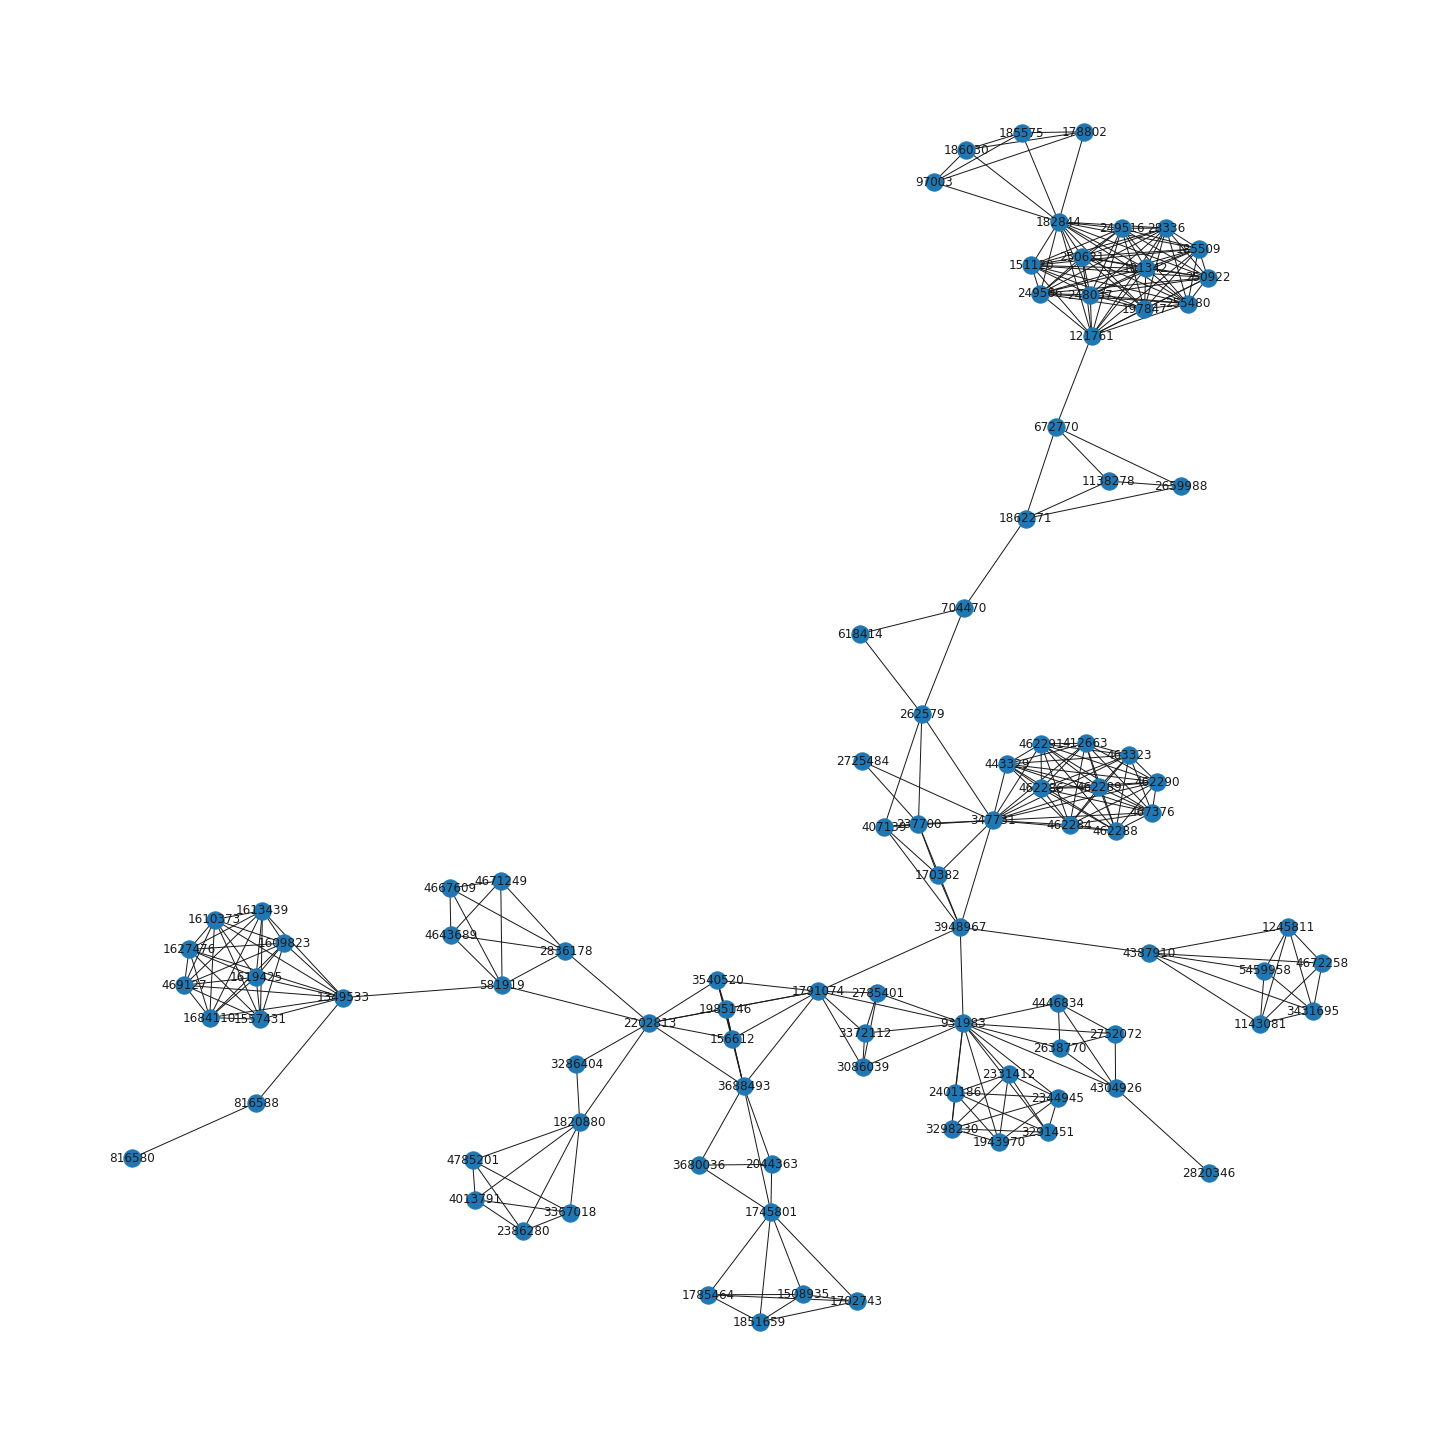

In [12]:
# plot community
third_community = meta_sub.subgraph(communities[3])
plt.figure(figsize=(20,20))
nx.draw_kamada_kawai(third_community, with_labels=True)

### Find groups with at least 3 users that were participated together in more than 10 competitions


In [13]:
# find out if a user participated in the same competition with different groups
all_teams = tc.SFrame.read_csv('./datasets/meta-kaggle/Teams.csv')
users_competitions = meta_sf.join(all_teams, on={'TeamId': 'Id'})
users_in_multiple_groups = users_competitions.groupby(['UserId', 'CompetitionId'], {'Num_of_groups_in_competition': agg.COUNT()})
print(users_in_multiple_groups[users_in_multiple_groups['Num_of_groups_in_competition'] > 1].shape[0])

Unexpected characters after last column. ""9"
"39871""
Parse failed at token ending at: 
	/14/2013","301721","301698","False","","","12","9"
"39871",^"3428","95327","Yilin Guo","","","","","False","
Successfully parsed 13 tokens: 
	0: 39870
	1: 3469
	2: 53187
	3: Parse","Breaker "
	4: /"
	5: 
	6: 04/14/2013
	7: 301721
	8: 301698
	9: False
	10: 
	11: 
	12: 12

1 lines failed to parse correctly

Finished parsing file /content/datasets/meta-kaggle/Teams.csv

Parsing completed. Parsed 100 lines in 0.843774 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,str,str,str,str,str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Unexpected characters after last column. ""9"
"39871""
Parse failed at token ending at: 
	/14/2013","301721","301698","False","","","12","9"
"39871",^"3428","95327","Yilin Guo","","","","","False","
Successfully parsed 13 tokens: 
	0: 39870
	1: 3469
	2: 53187
	3: "Parse""," ... eaker \""\
	4: /"
	5: 
	6: 04/14/2013
	7: 301721
	8: 301698
	9: False
	10: 
	11: 
	12: 12

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"358000","5340","",^"/╲/\╭( ͡° ͡° ͜ʖ ͡° ͡°)╮/\╱\",
Successfully parsed 2 tokens: 
	0: 358000
	1: 5340

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1119236","7880","",^"Competition Wizard Sample Submission Playground","","","","","True","","","",""
Successfully parsed 2 tokens: 
	0: 1119236
	1: 7880

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1119432","7880","",^"""Beet"" the Benchmark","","11/21/2017","5918756","5918756","True","","","",""
Successfully parsed 2 tokens: 
	0: 1119432
	1: 7880

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1119600","7878","",^"Competition Wizard Sample Submission Playground","","","","","True","","","",""
Successfully parsed 2 tokens: 
	0: 1119600
	1: 7878

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1121830","7886","",^"Competition Wizard Sample Submission Playground","","","","","True","","","",""
Successfully parsed 2 tokens: 
	0: 1121830
	1: 7886

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1121855","7886","",^"baseline.csv","","11/22/2017","5924604","5924604","True","","","",""
Successfully parsed 2 tokens: 
	0: 1121855
	1: 7886

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1122530","7867","",^"Competition Wizard Sample Submission Playground","","","","","True","","","",""
Successfully parsed 2 tokens: 
	0: 1122530
	1: 7867

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1123044","7880","",^"Corny Benchmark","","11/22/2017","5927628","5927628","True","","","",""
Successfully parsed 2 tokens: 
	0: 1123044
	1: 7880

Unable to interpret """" as a integer
Parse failed at token ending at: 
	"1123371","7886","",^"sample_submission.csv","","11/22/2017","5928672","5928672","True","","","",""
Successfully parsed 2 tokens: 
	0: 1123371
	1: 7886

Read 27612 lines. Lines per second: 10538.8

Read 1375456 lines. Lines per second: 175647

Read 1586411 lines. Lines per second: 121983

3834 lines failed to parse correctly

Finished parsing file /content/datasets/meta-kaggle/Teams.csv

Parsing completed. Parsed 2250407 lines in 14.1013 secs.

46340


In [14]:
# find out if each teamId is unique for every competition
teams_competitions = users_competitions[['TeamId', 'CompetitionId']].drop_duplicates(subset= ['TeamId', 'CompetitionId'])
len(teams_competitions['TeamId'].unique()) == teams_competitions['TeamId'].shape[0]

True

In [15]:
# find groups with at least 3 users which participated together more than 10 times
teams_users = meta_sf[['TeamId', 'UserId']].drop_duplicates(subset=['TeamId', 'UserId'])

# group teams by teamid to find teammates
teams_users = teams_users.groupby('TeamId', {'Teammates': agg.CONCAT('UserId')})

# find teams with more than 3 teammates
teams_gt_three = teams_users[teams_users['Teammates'].apply(lambda t: len(t) >= 3)]
# sort teammates by name
teams_gt_three['Teammates'] = teams_gt_three.apply(lambda r : sorted(r['Teammates']))

# add competition id for each team
teams_gt_three_comp = teams_gt_three.join(teams_competitions, on='TeamId', how='left')
# remove same team for same competition if exists
teams_gt_three_comp = teams_gt_three_comp.drop_duplicates(subset=['TeamId', 'CompetitionId'])
# remove same teammates for same competition if exists
teams_gt_three_comp = teams_gt_three_comp.drop_duplicates(subset=['Teammates', 'CompetitionId'])

# group by teams by teammates and count the number of competitions they have participated
teams_gt_three_comp_gb = teams_gt_three_comp.groupby(['Teammates'], {'Number_of_Competitions': agg.COUNT()})
# get only teams which participated in more than 10 competitions
best_teammates = teams_gt_three_comp_gb[teams_gt_three_comp_gb['Number_of_Competitions'] >= 10]
best_teammates.materialize()

print("All groups with at least 3 teammates that were participated together in 10 competitions minimum: ")
print(best_teammates)

All groups with at least 3 teammates that were participated together in 10 competitions minimum: 
+-------------------------------+------------------------+
|           Teammates           | Number_of_Competitions |
+-------------------------------+------------------------+
| [4439585.0, 4647558.0, 590... |           10           |
| [4471048.0, 4648702.0, 466... |           12           |
|  [13343.0, 13652.0, 13656.0]  |           10           |
| [3428214.0, 5439220.0, 722... |           10           |
| [3594546.0, 3597476.0, 461... |           10           |
| [4041944.0, 4765845.0, 476... |           11           |
+-------------------------------+------------------------+
[6 rows x 2 columns]



### Forum topics and how it was changed over the years

In [16]:
# load forum messages and forum topics
meta_forum_messages = pd.read_csv("./datasets/meta-kaggle/ForumMessages.csv")[['ForumTopicId', 'PostDate', 'Message']]
meta_forum_topics = pd.read_csv("./datasets/meta-kaggle/ForumTopics.csv")[['Id', 'Title']]

In [17]:
# drop na rows
meta_forum_messages.dropna(subset=['Message', 'PostDate'], inplace=True)
meta_forum_topics.dropna(subset=['Id'], inplace=True)

In [18]:
# convert type of columns in order to load data into an sframe
meta_forum_messages['ForumTopicId'] = meta_forum_messages['ForumTopicId'].astype(int)
meta_forum_messages['Message'] = meta_forum_messages['Message'].astype(str)

meta_forum_topics['Id'] = meta_forum_topics['Id'].astype(int)
meta_forum_topics['Title'] = meta_forum_topics['Title'].astype(str)

meta_forum_messages = tc.SFrame(meta_forum_messages)
meta_forum_topics = tc.SFrame(meta_forum_topics)

In [19]:
# get year of postDate
r = re.compile('\\d{4}')
def get_year(y_str):
    l = r.findall(y_str) # take the first year
    if len(l) == 0:
        return None
    return int(l[0])

meta_forum_messages['PostDate'] = meta_forum_messages['PostDate'].apply(lambda s: get_year(s))

In [20]:
# join between forum messages and forum topics by ForumTopicId
forum_messages_full = meta_forum_messages.join(meta_forum_topics, on={'ForumTopicId' : 'Id'}, how= 'left')
forum_messages_full

ForumTopicId,PostDate,Message,Title
16,2010,Here are some papers thatanalyze Eurovision vo ...,Studies that look atEurovision voting ...
16,2010,More research...enjoy<br><br>Love thy ...,Studies that look atEurovision voting ...
216,2010,Is there a time orderbetween the training and ...,Time order?
216,2010,No the whole network wassampled within a few ...,Time order?
163,2010,"Hi all,<br><br>Just tolet you know that we ...",Deadline extension
197,2010,120822+164809 rows&nbsp;x61 cols of data. Python ...,Sample Python Code
197,2010,I'm not sure you'veactually tried it. ...,Sample Python Code
197,2010,Just tell me how long ittakes for python to read ...,Sample Python Code
197,2010,mines between 5.7 and 5.9seconds. &nbsp;Sure ...,Sample Python Code
197,2010,Can you post code forloading and parsing? ...,Sample Python Code


In [21]:
# concatenate between forum message and forum topic
def get_full_text(topic_title, message):
  text = ""
  if topic_title is not None:
    text += topic_title
  if message is not None:
    text += "\n\n" + message
  return text.lower()

forum_messages_full['all_text'] = forum_messages_full.apply(lambda row: get_full_text(row['Title'], row['Message']))

# print 5 examples of the text
for i in range(5):
  print(forum_messages_full['all_text'][i])
  print('-'*80)

studies that look at eurovision voting patterns

here are some papers that analyze eurovision voting patterns. you might find some of them helpful. <br><br>gatherer (2006)<br>comparison of eurovision song contest simulation with actual results reveals shifting patterns of collusive voting alliances. <br><a target="_blank" title="http://jasss.soc.surrey.ac.uk/9/2/1.html" mce_href="http://jasss.soc.surrey.ac.uk/9/2/1.html" href="http://jasss.soc.surrey.ac.uk/9/2/1.html">http://jasss.soc.surrey.ac.uk/9/2/1.html<br></a><br>the eurovision song contest is voting political or cultural? <br>ginburgh and noury (2006)<br><a target="_blank" title="http://164.15.69.62/ecare/personal/ginsburgh/papers/153.eurovision.pdf" mce_href="http://164.15.69.62/ecare/personal/ginsburgh/papers/153.eurovision.pdf" href="http://164.15.69.62/ecare/personal/ginsburgh/papers/153.eurovision.pdf">http://164.15.69.62/ecare/personal/ginsburgh/papers/153.eurovision.pdf</a><br><br>fenn, suleman, efstathiou and johnson (20

We can see that the text has many html tags, lets remove it.

In [22]:
# regular expression for removing html tags and html objects (e.g &nbsp)
html_re = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6})')

# remove html urls from text
def remove_htmls_urls(raw_html):
  cleantext = re.sub(html_re, ' ', raw_html)
  cleantext = re.sub(r'http\S+', '', cleantext)
  cleantext = re.sub(' +', ' ', cleantext)
  return cleantext

forum_messages_full['all_text'] = forum_messages_full.apply(lambda row: remove_htmls_urls(row['all_text']))

# print 5 examples after removing html urls
for i in range(5):
  print(forum_messages_full['all_text'][i])
  print('-'*80)

studies that look at eurovision voting patterns

here are some papers that analyze eurovision voting patterns. you might find some of them helpful. gatherer (2006) comparison of eurovision song contest simulation with actual results reveals shifting patterns of collusive voting alliances. the eurovision song contest is voting political or cultural? ginburgh and noury (2006) fenn, suleman, efstathiou and johnson (2008) the eurovision song contest as a ‘friendship’ network 
dekker (2007) 
 
--------------------------------------------------------------------------------
studies that look at eurovision voting patterns

more research... enjoy love thy neighbor, love thy kin: voting biases in the eurovision song contest geography, culture, and religion: explaining the bias in eurovision song contest voting a hybrid system approach to determine the ranking of a debutant country in eurovision googling eurovision expert judgment versus public opinion – evidence from the eurovision song contest

In [23]:
# find common words
txt = "\n".join(forum_messages_full['all_text'][:1000])
l = [w for w in re.findall(r"(\w+)", txt)]
d = Counter(l)
d.most_common(100)

[('the', 4658),
 ('to', 2350),
 ('i', 2008),
 ('of', 1701),
 ('a', 1593),
 ('in', 1509),
 ('and', 1502),
 ('is', 1341),
 ('for', 1222),
 ('that', 1181),
 ('you', 994),
 ('it', 978),
 ('0', 834),
 ('data', 826),
 ('this', 815),
 ('be', 725),
 ('x', 725),
 ('on', 682),
 ('not', 612),
 ('with', 548),
 ('t', 547),
 ('have', 526),
 ('are', 516),
 ('if', 507),
 ('as', 486),
 ('but', 466),
 ('s', 456),
 ('1', 450),
 ('can', 415),
 ('or', 414),
 ('my', 374),
 ('your', 368),
 ('at', 351),
 ('will', 351),
 ('what', 330),
 ('would', 326),
 ('was', 323),
 ('item', 314),
 ('my_document_features', 311),
 ('from', 297),
 ('an', 296),
 ('using', 294),
 ('we', 293),
 ('there', 287),
 ('quote', 286),
 ('so', 280),
 ('use', 277),
 ('2', 269),
 ('by', 262),
 ('all', 258),
 ('which', 250),
 ('some', 239),
 ('they', 237),
 ('more', 218),
 ('do', 218),
 ('set', 218),
 ('thanks', 215),
 ('time', 214),
 ('how', 211),
 ('just', 208),
 ('one', 207),
 ('competition', 204),
 ('information', 197),
 ('am', 184),
 ('

A lot of stop words, numbers and one word letters

In [26]:
stemmer = PorterStemmer()
stop_words_set = set(stopwords.words("english"))

# skip words with less than 2 chars, stop words and numbers
def skip_word(word):
  if len(word) < 2:
    return True
  if word in stop_words_set:
    return True
  if word.isdigit():
    return True
  return False

# remove ngrams with nubmers, stopwords and short words
def skip_ngrams(ngram):
  for w in ngram.split():
    if skip_word(w):
      return True
  return False

def word_stemming(w):
  return stemmer.stem(w)

In [27]:
# clean text and create also stemming text
forum_messages_full['clean_text'] = forum_messages_full['all_text'].apply(lambda text: " ".join([w for w in word_tokenize(text) if not skip_word(w)]))
forum_messages_full['stem_text'] = forum_messages_full['clean_text'].apply(lambda text: " ".join([word_stemming(w) for w in word_tokenize(text)]))
forum_messages_full

ForumTopicId,PostDate,Message,Title,all_text
16,2010,Here are some papers thatanalyze Eurovision vo ...,Studies that look atEurovision voting ...,studies that look ateurovision voting ...
16,2010,More research...enjoy<br><br>Love thy ...,Studies that look atEurovision voting ...,studies that look ateurovision voting ...
216,2010,Is there a time orderbetween the training and ...,Time order?,time order?\n\nis there atime order between the ...
216,2010,No the whole network wassampled within a few ...,Time order?,time order?\n\nno thewhole network was sam ...
163,2010,"Hi all,<br><br>Just tolet you know that we ...",Deadline extension,"deadline extension\n\nhiall, just to let you ..."
197,2010,120822+164809 rows&nbsp;x61 cols of data. Python ...,Sample Python Code,sample pythoncode\n\n120822+164809 ...
197,2010,I'm not sure you'veactually tried it. ...,Sample Python Code,sample python code\n\ni'mnot sure you've actually ...
197,2010,Just tell me how long ittakes for python to read ...,Sample Python Code,sample pythoncode\n\njust tell me how ...
197,2010,mines between 5.7 and 5.9seconds. &nbsp;Sure ...,Sample Python Code,sample pythoncode\n\nmines between ...
197,2010,Can you post code forloading and parsing? ...,Sample Python Code,sample python code\n\ncanyou post code for loa ...


In [28]:
# sample 100000 samples
sample_data = forum_messages_full[:100000]

# docs = tc.text_analytics.count_ngrams(sample_data['clean_text'], n=2, method='word')
docs = tc.text_analytics.count_words(sample_data['clean_text'])
docs = docs.apply(lambda d: {words:v for words,v in d.items() if not skip_ngrams(words)})

In [29]:
# set number of topics and split data into train and test
n_topics = 50
train_data, test_data = tc.text_analytics.random_split(docs, prob=0.2)

In [30]:
# find best number of topics
results = {}
for i in range(100, 201, 10):
  m = tc.topic_model.create(train_data)
  pred = m.predict(train_data, output_type='probability')
  topics = m.topics
  p = tc.topic_model.perplexity(test_data, pred,
                                topics['topic_probabilities'],
                                topics['vocabulary'])
  results[f'#{i}'] = p
  print(p)
results

Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.98s         | 5.50572e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2941.4025568121524


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.91s         | 5.69161e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2903.5476602945246


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.95s         | 6.1152e+06     | 0               |

+-----------+---------------+----------------+-----------------+

2904.58953271608


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 5.03s         | 5.68555e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2918.037643858912


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.82s         | 6.04486e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2940.524883052992


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.97s         | 6.00929e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2900.2976087933325


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 5.00s         | 5.99419e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2920.525922086631


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.88s         | 5.89032e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2930.240374455043


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 5.08s         | 5.63359e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2944.1703063978844


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.88s         | 5.4189e+06     | 0               |

+-----------+---------------+----------------+-----------------+

2936.9147481607706


Learning a topic model

Number of documents    100000

Vocabulary size     69570

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 4.93s         | 6.01085e+06    | 0               |

+-----------+---------------+----------------+-----------------+

2936.537583692889


{'#100': 2941.4025568121524,
 '#110': 2903.5476602945246,
 '#120': 2904.58953271608,
 '#130': 2918.037643858912,
 '#140': 2940.524883052992,
 '#150': 2900.2976087933325,
 '#160': 2920.525922086631,
 '#170': 2930.240374455043,
 '#180': 2944.1703063978844,
 '#190': 2936.9147481607706,
 '#200': 2936.537583692889}

In [36]:
# create topic model with the best number of topics = 110
topic_model = tc.topic_model.create(docs, num_topics = 110)

Learning a topic model

Number of documents    100000

Vocabulary size     76479

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 13.36s        | 2.72373e+06    | 0               |

In [37]:
# get topics
topics_sf = topic_model.topics

# get best words of the given topic
def get_topic_best_match_words(topic_sf, topic_num, n):
    d = {r['vocabulary']: r['topic_probabilities'][topic_num] for r in topics_sf}
    l = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    return l[:n]

# print examples
print(f"10 representing words of topic number 10: ")
display(get_topic_best_match_words(topics_sf, 10, 10))

+-----------+---------------+----------------+-----------------+

10 representing words of topic number 10: 


[('submission', 0.07759736532279281),
 ('model', 0.051844881806423986),
 ('deadline', 0.021972901363922735),
 ('final', 0.021792814066605472),
 ('would', 0.019541722850139664),
 ('first', 0.01877635183654129),
 ('think', 0.018371155417577445),
 ('could', 0.01600750964028835),
 ('competition', 0.013981527545469124),
 ('submitted', 0.011055108964063576)]

In [38]:
# set for each text its best topic
sample_data['Topic'] = topic_model.predict(docs)

# count the number of times each topic was discussed in each year
year_topics_gb = sample_data.groupby(['PostDate', 'Topic'], {'Topic_counter': agg.COUNT()})

year_topics_gb

PostDate,Topic,Topic_counter
2016,91,377
2010,9,8
2014,79,150
2013,58,97
2010,2,2
2013,0,178
2014,103,206
2011,48,154
2010,106,17
2014,41,263


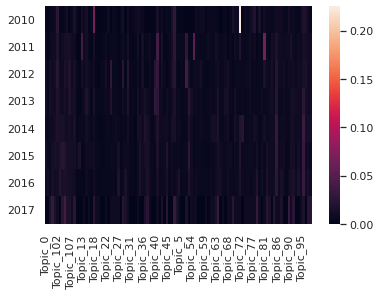

In [39]:
# convert the data into a heatmap - yaxis = year, xaxis=topic, counter = the values inside.
def convert_to_heatmap(data):
  x_dates = data['PostDate'].unique()
  y_topics = data['Topic'].unique()
  df_dict = {}
  for topic in y_topics:
    for date in x_dates:
      if date not in df_dict:
        df_dict[date] = []
      count = data[(year_topics_gb['Topic'] == topic) & (data['PostDate'] == date)]
      if len(count) > 0:
        df_dict[date].append(count[0]['Topic_counter'])
      else:
        df_dict[date].append(0)

  df = pd.DataFrame.from_dict(df_dict, orient='index', columns = [f'Topic_{i}' for i in y_topics])
  df = df.div(df.sum(axis=1), axis=0)
  df = df.sort_index()
  df = df.reindex(sorted(df.columns), axis=1)
  sns.heatmap(df)

convert_to_heatmap(year_topics_gb)

In [40]:
import plotly.express as px
px.scatter(year_topics_gb.to_dataframe(), x="PostDate", y="Topic", size='Topic_counter', size_max=20)

### Programming languages and code libraries

In [ ]:
# create meta kaggle dir
!mkdir ./datasets
!mkdir ./datasets/meta-kaggle
!mkdir ./datasets/meta-kaggle/ProLang

# download the dataset from Kaggle and unzip it
!kaggle datasets download -d stackoverflow/stacksample -f Tags.csv -p ./datasets/meta-kaggle/ProLang
!unzip ./datasets/meta-kaggle/ProLang/*.zip  -d ./datasets/meta-kaggle/ProLang

# delete all zip files
directory = './datasets/meta-kaggle/ProLang'
for file in os.listdir(directory):
  if file.endswith('.zip'):
    os.remove(os.path.join(directory, file))

In [ ]:
# load list of programming languages and technologies from kaggle dataset
libs_langs_df = pd.read_csv('./datasets/meta-kaggle/ProLang/Tags.csv', encoding="ISO-8859-1", dtype={'Tag': str})['Tag']
libs_langs_df = libs_langs_df.dropna()
count_lib_lang = Counter(libs_langs_df.values)
top_lib_lang = count_lib_lang.most_common(2000)
top_lib_lang[:10]

[('javascript', 124155),
 ('java', 115212),
 ('c#', 101186),
 ('php', 98808),
 ('android', 90659),
 ('jquery', 78542),
 ('python', 64601),
 ('html', 58976),
 ('c++', 47591),
 ('ios', 47009)]

In [ ]:
# create patterns of programming langugages and technologies (all tech in lower case + special languages like c#, c++ etc.)
def create_patterns(data):
    versioned_patterns = [[{'LOWER': lang}] for lang in data]

    lang_patterns = [
        [{'LOWER': 'objective'}, {'IS_PUNCT': True, 'OP': '?'},{'LOWER': 'c'}],
        [{'LOWER': 'objectivec'}],
        [{'LOWER': 'c'}, {'LOWER': '#'}],
        [{'LOWER': 'c'}, {'LOWER': 'sharp'}],
        [{'LOWER': 'c#'}],
        [{'LOWER': 'go', 'POS': {'NOT_IN': ['VERB']}}],
        [{'LOWER': 'golang'}],
        [{'LOWER': 'html'}],
        [{'LOWER': 'css'}],
        [{'LOWER': 'sql'}],
        [{'LOWER': {'IN': ['js', 'javascript']}}],
        [{'LOWER': 'c++'}],
    ]

    return versioned_patterns + lang_patterns

# create a spacy matcher to match these patterns
libs_langs = [name for name, count in top_lib_lang]
all_patterns = create_patterns(libs_langs)
matcher = Matcher(nlp.vocab, validate=True)
matcher.add("LIB_PROG_LANG", all_patterns)

In [ ]:
def parse_train_data(doc):
    detections = [(doc[start:end].start_char, doc[start:end].end_char, 'LIB_PROG_LANG') for idx, start, end in matcher(doc)]
    return (doc.text, {'entities': detections})

# parse samples of forum messages and train spacy ner model
sample_messages_df = meta_forum_messages[:2000]
sample_messages_df['Message'] = sample_messages_df['Message'].apply(lambda r: r.lower())
messages = sample_messages_df['Message'][:2000]

train_data = [parse_train_data(d) for d in nlp.pipe(messages) if len(matcher(d)) == 1]

# print example
start = train_data[50][1]['entities'][0][0]
end = train_data[50][1]['entities'][0][1]
train_data[50][0][int(start):int(end)]

'this'

In [ ]:
# create an empty nlp ner model
def create_blank_nlp(train_data):
    nlp = spacy.blank("en")
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
    ner = nlp.get_pipe("ner")
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
    return nlp

nlp = create_blank_nlp(train_data)

In [ ]:
# train an NER model
optimizer = nlp.begin_training()
for i in nt_tqdm(range(20)):
    losses = {}
    batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(
            texts,  # batch of texts
            annotations,  # batch of annotations
            drop=0.1,  # dropout
            losses=losses,
        )
        
    print(f"Losses at iteration {i} - {losses}")
    if losses['ner'] < 1 : break

  5%|▌         | 1/20 [00:05<01:41,  5.36s/it]

Losses at iteration 0 - {'ner': 1182.848863500964}


 10%|█         | 2/20 [00:10<01:32,  5.14s/it]

Losses at iteration 1 - {'ner': 149.23116755373985}


 15%|█▌        | 3/20 [00:15<01:26,  5.09s/it]

Losses at iteration 2 - {'ner': 38.87607271824212}


 20%|██        | 4/20 [00:20<01:20,  5.05s/it]

Losses at iteration 3 - {'ner': 19.93657186243112}


 25%|██▌       | 5/20 [00:25<01:15,  5.05s/it]

Losses at iteration 4 - {'ner': 21.86082477019193}


 30%|███       | 6/20 [00:30<01:10,  5.03s/it]

Losses at iteration 5 - {'ner': 15.080450569650147}


 35%|███▌      | 7/20 [00:35<01:05,  5.03s/it]

Losses at iteration 6 - {'ner': 6.569498871858812}


 40%|████      | 8/20 [00:40<01:00,  5.04s/it]

Losses at iteration 7 - {'ner': 8.17436667106194}


 45%|████▌     | 9/20 [00:45<00:55,  5.08s/it]

Losses at iteration 8 - {'ner': 2.7729619888444477}


 50%|█████     | 10/20 [00:50<00:51,  5.14s/it]

Losses at iteration 9 - {'ner': 7.40404260193247}


 55%|█████▌    | 11/20 [00:56<00:46,  5.18s/it]

Losses at iteration 10 - {'ner': 0.7122776521694983}


 60%|██████    | 12/20 [01:01<00:41,  5.18s/it]

Losses at iteration 11 - {'ner': 0.09800623553802536}


 65%|██████▌   | 13/20 [01:06<00:36,  5.17s/it]

Losses at iteration 12 - {'ner': 4.3755034847865995}


 70%|███████   | 14/20 [01:11<00:30,  5.15s/it]

Losses at iteration 13 - {'ner': 8.279388729459236e-06}


 75%|███████▌  | 15/20 [01:16<00:25,  5.11s/it]

Losses at iteration 14 - {'ner': 8.13693811697189}


 80%|████████  | 16/20 [01:21<00:20,  5.08s/it]

Losses at iteration 15 - {'ner': 4.533206838542661}


 85%|████████▌ | 17/20 [01:26<00:15,  5.09s/it]

Losses at iteration 16 - {'ner': 22.86188561134025}


 90%|█████████ | 18/20 [01:31<00:10,  5.07s/it]

Losses at iteration 17 - {'ner': 19.75968759488097}


 95%|█████████▌| 19/20 [01:36<00:05,  5.08s/it]

Losses at iteration 18 - {'ner': 16.899246325224112}


100%|██████████| 20/20 [01:42<00:00,  5.11s/it]

Losses at iteration 19 - {'ner': 3.9172024793989633}


In [ ]:
# test model
doc1 = nlp("i write code in python")
displacy.render(doc1, style="ent", jupyter=True)

In [ ]:
tqdm.pandas()

def get_entites_from_text(text):
    entities_list = set()
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        entities_list.add(entity.text)        
    return entities_list

# iterate over all messages and find entities in text
sample_messages_dfp = sample_messages_df.to_dataframe()
sample_messages_dfp['EntitiesList'] = sample_messages_dfp['Message'].progress_apply(lambda t: get_entites_from_text(t))
# print example
sample_messages_dfp['EntitiesList'][0]

100%|██████████| 2000/2000 [00:22<00:00, 88.03it/s]


{'python'}

In [ ]:
# convert data into sframe
sample_messages_sf = tc.SFrame(sample_messages_dfp)
# groupby all message by date and concat all entities
entities_by_year = sample_messages_sf.groupby('PostDate', {'AllEntities': agg.CONCAT('EntitiesList')})
# combine all entities
entities_by_year['AllEntities'] = entities_by_year['AllEntities'].apply(lambda l: [item for sublist in l for item in sublist])

# count the number of times each topis was discussed on each year
years_entities = {}
for year in entities_by_year['PostDate']:
  years_entities[year] = Counter(entities_by_year[entities_by_year['PostDate'] == year]['AllEntities'][0])

# print examples
for year, entities in years_entities.items():
    print(f"The top 5 programming languages/libraries are at {year}:")
    print(entities.most_common(5))
    print("-" * 50)

The top 5 programming languages/libraries are at 2011:
[('this', 136), ('get', 30), ('r', 27), ('size', 21), ('post', 20)]
--------------------------------------------------
The top 5 programming languages/libraries are at 2010:
[('this', 38), ('size', 24), ('model', 15), ('time', 14), ('uri', 10)]
--------------------------------------------------
The top 5 programming languages/libraries are at 2012:
[('this', 188), ('set', 46), ('file', 31), ('where', 26), ('find', 21)]
--------------------------------------------------
The top 5 programming languages/libraries are at 2013:
[('this', 39), ('time', 12), ('model', 8), ('set', 8), ('random', 8)]
--------------------------------------------------


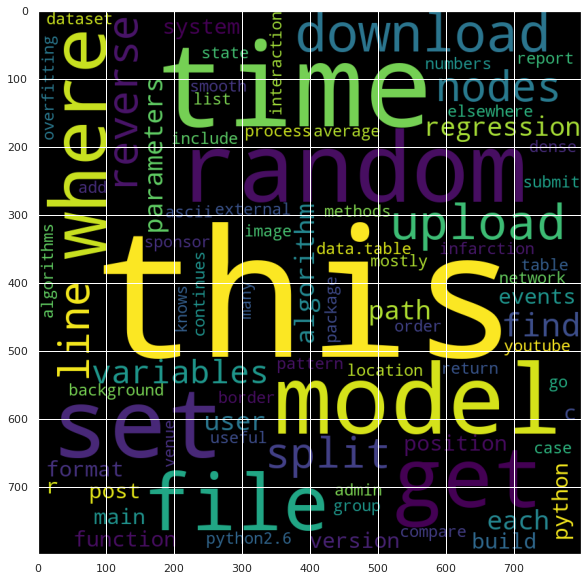

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 5)
wordcloud.generate_from_frequencies(frequencies=years_entities[2013])
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud)

# Question 3

In [4]:
# Creating a dataset directory
if not os.path.exists('./datasets') or not os.path.isdir('./datasets'):
  !mkdir ./datasets

# create meta kaggle dir
!mkdir ./datasets/olympic_games

# download the dataset from Kaggle and unzip it 
!kaggle datasets download -d heesoo37/120-years-of-olympic-history-athletes-and-results -f athlete_events.csv -p ./datasets/olympic_games

!unzip ./datasets/olympic_games/*.zip  -d ./datasets/olympic_games/

# delete all zip files
directory = './datasets/olympic_games'
for file in os.listdir(directory):
  if file.endswith('.zip'):
    os.remove(os.path.join(directory, file))

mkdir: cannot create directory ‘./datasets/olympic_games’: File exists
athlete_events.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/olympic_games/athlete_events.csv.zip
  inflating: ./datasets/olympic_games/athlete_events.csv  


In [6]:
# read 120 years olympic data from kaggle
olympic_sf = tc.SFrame.read_csv('./datasets/olympic_games/athlete_events.csv')
olympic_sf 

Finished parsing file /content/datasets/olympic_games/athlete_events.csv

Parsing completed. Parsed 100 lines in 5.02219 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,int,float,str,str,str,int,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/datasets/olympic_games/athlete_events.csv

Parsing completed. Parsed 271116 lines in 2.86784 secs.

ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season
1,A Dijiang,M,24,180,80.0,China,CHN,1992 Summer,1992,Summer
2,A Lamusi,M,23,170,60.0,China,CHN,2012 Summer,2012,Summer
3,Gunnar Nielsen Aaby,M,24,None,None,Denmark,DEN,1920 Summer,1920,Summer
4,Edgar Lindenau Aabye,M,34,None,None,Denmark/Sweden,DEN,1900 Summer,1900,Summer
5,Christine Jacoba Aaftink,F,21,185,82.0,Netherlands,NED,1988 Winter,1988,Winter
5,Christine Jacoba Aaftink,F,21,185,82.0,Netherlands,NED,1988 Winter,1988,Winter
5,Christine Jacoba Aaftink,F,25,185,82.0,Netherlands,NED,1992 Winter,1992,Winter
5,Christine Jacoba Aaftink,F,25,185,82.0,Netherlands,NED,1992 Winter,1992,Winter
5,Christine Jacoba Aaftink,F,27,185,82.0,Netherlands,NED,1994 Winter,1994,Winter
5,Christine Jacoba Aaftink,F,27,185,82.0,Netherlands,NED,1994 Winter,1994,Winter


In [23]:
# group all data according to the players ID and the games they participated and concatenate the mdelas they won
olympic_sf_gb = olympic_sf.groupby(['ID', 'Games'], {'Medals': agg.CONCAT('Medal')})

# add column for each player his number of medals in a specific olympic tournement
olympic_sf_gb['Number_of_Medals'] =  olympic_sf_gb.apply(lambda r: len(r['Medals']))

# tag all players with more than 3 medals on the same olmympic game as Great
olympic_sf_gb['isGreat'] = olympic_sf_gb.apply( lambda r: r['Number_of_Medals'] >= 3)
olympic_sf_gb.materialize()
olympic_sf_gb

Games,ID,Medals,Number_of_Medals,isGreat
2006 Winter,14604,[],0,0
2010 Winter,52668,[],0,0
1956 Winter,15857,[],0,0
1996 Summer,116720,[],0,0
1964 Summer,8340,[],0,0
1980 Summer,103114,[],0,0
1988 Summer,85525,[],0,0
1960 Summer,43793,[],0,0
1988 Summer,20338,[],0,0
1992 Summer,18847,[],0,0


In [25]:
# train a simple model which classifies if a player has great results or not
train, test = olympic_sf_gb.random_split(0.8)
cls = tc.classifier.create(train, features=['Number_of_Medals'], target="isGreat")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 142325

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.077503     | 1.000000          | 1.000000            | 0.437500          | 0.437500            |

| 2         | 0.124007     | 1.000000          | 1.000000            | 0.296298          | 0.296298            |

| 3         | 0.171507     | 1.000000          | 1.000000            | 0.207324          | 0.207324            |

| 4         | 0.211501     | 1.000000          | 1.000000            | 0.147798          | 0.147798            |

| 5         | 0.261561     | 1.000000          | 1.000000            | 0.106606          | 0.106606            |

| 10        | 0.484457     | 1.000000          | 1.000000            | 0.022525          | 0.022526            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 142325

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.058756     | 1.000000          | 1.000000            | 0.126945          | 0.126945            |

| 2         | 0.102994     | 1.000000          | 1.000000            | 0.126945          | 0.126945            |

| 3         | 0.149764     | 1.000000          | 1.000000            | 0.126945          | 0.126945            |

| 4         | 0.198183     | 1.000000          | 1.000000            | 0.126945          | 0.126945            |

| 5         | 0.243527     | 1.000000          | 1.000000            | 0.126945          | 0.126945            |

| 10        | 0.460139     | 1.000000          | 1.000000            | 0.126945          | 0.126945            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 142325

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.071247     | 1.000000          | 1.000000            | 0.126941          | 0.126941            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 142325

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 5.000000  | 0.113966     | 0.995791          | 0.995728            |

| 1         | 12       | 17.981091 | 0.351567     | 0.997056          | 0.997197            |

| 2         | 13       | 17.981091 | 0.410347     | 0.985955          | 0.985049            |

| 3         | 17       | 1.417038  | 0.535915     | 0.997056          | 0.997197            |

| 4         | 20       | 1.061659  | 0.646385     | 0.997056          | 0.997197            |

Warning: Reached max step size.

| 9         | 36       | 3.403489  | 1.087569     | 1.000000          | 1.000000            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 142325

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients      : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.175073     | 0.995791          | 0.995728            |

| 2         | 3        | 0.279242     | 0.995960          | 0.996129            |

| 3         | 4        | 0.369365     | 0.997056          | 0.997197            |

| 4         | 5        | 0.459765     | 0.997056          | 0.997197            |

| 5         | 6        | 0.551403     | 1.000000          | 1.000000            |

| 10        | 11       | 0.990244     | 1.000000          | 1.000000            |

+-----------+----------+--------------+-------------------+---------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 1.0
PROGRESS: RandomForestClassifier          : 1.0
PROGRESS: DecisionTreeClassifier          : 1.0
PROGRESS: SVMClassifier                   : 1.0
PROGRESS: LogisticClassifier              : 1.0
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [26]:
# evaluate the classifier
cls.evaluate(test)

{'accuracy': 1.0, 'auc': 1.0, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 2
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  153  |
 |      0       |        0        | 37483 |
 +--------------+-----------------+-------+
 [2 rows x 3 columns], 'f1_score': 1.0, 'log_loss': 0.022525256074639455, 'precision': 1.0, 'recall': 1.0, 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+-----+-------+
 | threshold | fpr | tpr |  p  |   n   |
 +-----------+-----+-----+-----+-------+
 |    0.0    | 1.0 | 1.0 | 153 | 37483 |
 |   0.001   | 1.0 | 1.0 | 153 | 37483 |
 |   0.002   | 1.0 | 1.0 | 153 | 37483 |
 |   0.003   | 1.0 | 1.0 | 153 | 37483 |
 |   0.004   | 1.0 | 1.0 | 153 | 37483 |
 |   0.005   | 1.0 | 1.0 | 153 | 37483 |
 |   0.006   | 1.0 | 1.0 